In [7]:
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import json

In [17]:
########## Récupération des valeurs dans les fichiers ##########
datafile = "1normal1000.json"
f = open(datafile, "r")
data_train = [json.loads(line) for line in f.readlines()]

datafile = "outlier.json"
f = open(datafile, "r")
data_test = [json.loads(line) for line in f.readlines()]

datafile = "2normal1000.json"
f = open(datafile, "r")
data_traintest = [json.loads(line) for line in f.readlines()]

f.close()

In [18]:
########## Formalisation des données  ##########

# Lecture des données pour l'apprentissage et création d'une liste pour chaque capteur
list_light, list_sound, list_temp_object, list_temp_ambient = [], [], [], []
for d in data_train:
    list_light.append(d["light"])
    list_sound.append(d["sound"])
    list_temp_object.append(d["temp"]["object"])
    list_temp_ambient.append(d["temp"]["ambient"])
    
# Conversion des listes en tableaux numpy
light_train = np.array(list_light)
sound_train = np.array(list_sound)
temp_object_train = np.array(list_temp_object)
temp_ambient_train = np.array(list_temp_ambient)

# Création d'un seul tableau (1000 listes de 4 valeurs) avec les valeurs des capteurs
train_values = np.stack((light_train,sound_train,temp_object_train,temp_ambient_train), axis=-1)

In [19]:
# Lecture des données normales pour la vérification et création d'une liste pour chaque capteur
l,s,to,ta = [],[],[],[]
for d in data_traintest:
    l.append(d["light"])
    s.append(d["sound"])
    to.append(d["temp"]["object"])
    ta.append(d["temp"]["ambient"])
# Conversion des listes en tableaux numpy
lt = np.array(l)
st = np.array(s)
tot = np.array(to)
tat = np.array(ta)
# Création d'un seul tableau (1000 listes de 4 valeurs) avec les valeurs des capteurs
traintest_values = np.stack((lt,st,tot,tat),axis=-1)

In [20]:
# Lecture des données pour le test et création d'une liste pour chaque capteur
list_l, list_s, list_to, list_ta = [], [], [], []
for d in data_test:
    list_l.append(d["light"])
    list_s.append(d["sound"])
    list_to.append(d["temp"]["object"])
    list_ta.append(d["temp"]["ambient"])
# Conversion des listes en tableaux numpy
light_test = np.array(list_l)
sound_test = np.array(list_s)
temp_object_test = np.array(list_to)
temp_ambient_test = np.array(list_ta)

# Création d'un seul tableau (1000 listes de 4 valeurs) avec les valeurs des capteurs
test_values = np.stack((light_test,sound_test,temp_object_test,temp_ambient_test),axis=-1)

In [21]:
########## Création des labels  ##########

# Création des tableaux labels pour chaque capteur avec 1 si les valeurs sont dans les bornes normales
test_labels_light = np.array([-1 if (x<10 or x>250) else 1 for x in light_test])
test_labels_sound = np.array([-1 if (x<0 or x>85) else 1 for x in sound_test])
test_labels_to = np.array([-1 if (x<15 or x>35) else 1 for x in temp_object_test])
test_labels_ta = np.array([-1 if (x<15 or x>35) else 1 for x in temp_ambient_test])

# Création du tableau de labels pour le test avec des seulement 1 si les 4 labels sont à 1 (potentiellement à modifier pour mettre des 1 si 3 des 4 labels sont à 1)
test_labels = np.array([1 if (a==1 and b==1 and c==1 and d==1) else -1 for (a,b,c,d) in zip(test_labels_light,test_labels_sound,test_labels_to,test_labels_ta)])

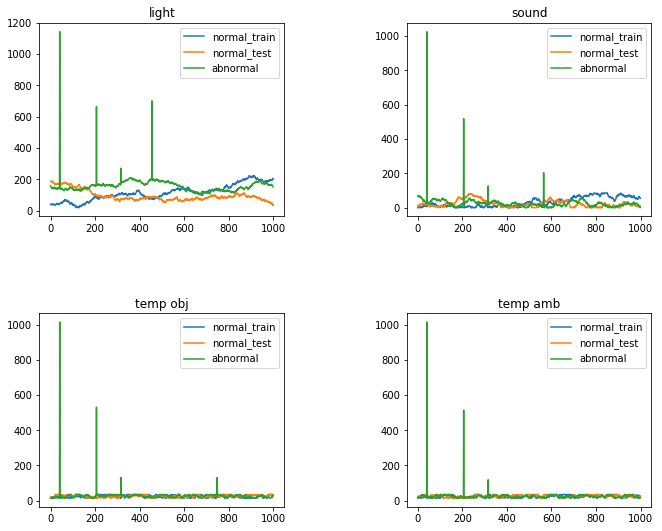

In [22]:
########## Affichage des données  ##########

plt.figure(1,figsize=(10, 8))

plt.subplot(221)
plt.plot(light_train,label="normal_train")
plt.plot(lt,label="normal_test")
plt.plot(light_test,label="abnormal")
plt.title("light")
plt.legend()

plt.subplot(222)
plt.plot(sound_train,label="normal_train")
plt.plot(st,label="normal_test")
plt.plot(sound_test,label="abnormal")
plt.title("sound")
plt.legend()

plt.subplot(223)
plt.plot(temp_object_train,label="normal_train")
plt.plot(tot,label="normal_test")
plt.plot(temp_object_test,label="abnormal")
plt.title("temp obj")
plt.legend()

plt.subplot(224)
plt.plot(temp_ambient_train,label="normal_train")
plt.plot(tat,label="normal_test")
plt.plot(temp_ambient_test,label="abnormal")
plt.title("temp amb")
plt.legend()

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.5)
plt.show()

In [23]:
########## Normalisation des données normales ##########

scaler = MinMaxScaler(feature_range=(0, 1))
train_values = scaler.fit_transform(train_values)
traintest_values = scaler.fit_transform(traintest_values)
test_values = scaler.fit_transform(test_values)

print(train_values.shape)
print(traintest_values.shape)
print(test_values.shape)

(1000, 4)
(1000, 4)
(1000, 4)


In [31]:
########## One-Class SVM classification  ##########

# fit the model
clf = svm.OneClassSVM(nu=0.001, kernel="rbf", gamma=0.1)

clf.fit(train_values)

y_pred_train = clf.predict(train_values)
y_pred_test = clf.predict(traintest_values)
y_pred_outliers = clf.predict(test_values)

n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

print("error train: ", n_error_train, "/1000 ; error test: ", n_error_test, "/1000 ; errors novel abnormal: ", n_error_outliers, "/1000")

print(y_pred_outliers)
print(test_labels)


error train:  3 /1000 ; error test:  3 /1000 ; errors novel abnormal:  343 /1000
[ 1  1  1  1  1  1 -1 -1  1  1  1 -1 -1 -1  1  1  1  1  1  1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1  1  1 -1  1
  1 -1 -1 -1 -1 -1  1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1  1
  1  1  1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1 -1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1
 -1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 